## Final Project Submission

Please fill out:
* Student name: Charlotte Basch
* Student pace: self paced / part time / <strong>full time</strong>
* Scheduled project review date/time: 11/4/2020, 2pm
* Instructor name: James Irving
* Blog post URL: https://charsarb.github.io/trying_to_make_a_neural_network_stable

# Introduction

&nbsp; &nbsp; &nbsp; As of April 30, 2020, Twitter <a href="https://s22.q4cdn.com/826641620/files/doc_financials/2020/q1/Q1-2020-Earnings-Press-Release.pdf" target="_blank">reported</a> 166 million daily users. In the United States, this includes <a href="https://www.pewresearch.org/fact-tank/2019/04/10/share-of-u-s-adults-using-social-media-including-facebook-is-mostly-unchanged-since-2018/" target="_blank">22% of adults</a>, who are in general young and relatively affluent. This makes Twitter an excellent resource for gauging consumer sentiment. That is the aim of this project. Using <a href="https://data.world/crowdflower/brands-and-product-emotions" target="_blank">data</a> from CrowdFlower, tweets about Apple and Google products were analyzed to be able to predict positive and negative sentiment. This dataset consists of 9,000 tweets labeled by individuals as positive, negative, neither, or marked as unknown. However only the positive and negative tweets were considered in the model. The data were analyzed by multiple Long Short Term Memory networks with different parameters. While none of the models performed ideally, the best model used a tokenizer created embedding layer, one LSTM layer with a tanh activation function and l1 regularization.  

# Data Cleaning and Exploration

## Importing Necessary Packages

In [1]:
#set random seeds
seed_value = 42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import numpy as np
import tensorflow as tf
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

C:\Users\charlotte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\charlotte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\charlotte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\charlotte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk import word_tokenize
import preprocessor as p
import sklearn.metrics as metrics
from gensim.utils import simple_preprocess
from tensorflow.keras import regularizers, optimizers, layers, initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS
import string
from nltk import FreqDist
import re
from nltk import word_tokenize
pd.set_option("display.max_rows", 500, "display.max_columns", None)

First we must import and preview the data. The column names are very cumbersome so for the sake of conciseness, we will rename them more simply. 

In [3]:
data = pd.read_csv("tweet_product_company.csv", encoding = "unicode_escape")
data = data.rename(columns={"emotion_in_tweet_is_directed_at": "product", 
                            "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"})
data.head()

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


We are not interested in the specific product at this time, just the tweet and the emotion it so we only look at these columns. We are also only interested in predicting positive or negative sentiment so we can eliminate the 'no emotion' and 'I can't tell' rows. This leaves us with an quite imbalanced dataset, with approximately 5 times more positive than negative tweets. 

In [4]:
data["emotion"].value_counts(normalize=True, dropna=False)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

In [5]:
data = data[data["emotion"] != "I can't tell"]
data = data.loc[(data["emotion"] != "I can't tell") & (data["emotion"] != "No emotion toward brand or product")]
data["emotion"].value_counts(normalize=True, dropna=False)

Positive emotion    0.839346
Negative emotion    0.160654
Name: emotion, dtype: float64

In [6]:
#Finish cleaning the outcome variable by making it numerical
data["emotion"] = data["emotion"].replace({"Negative emotion": 0, 
                                                    "Positive emotion": 1})

## Preprocess the Text

In [7]:
#Make a copy of the data to clean and get rid of the product column
data_cleaned = data.copy()
data_cleaned = data_cleaned.drop(columns=["product"])

In order to prepare the tweets for modeling we must get rid of the irrelevant information including emojis, urls, and mentions. In addition there are some html character entity references such as using 'quot' preceded by an ampersand and followed by a semicolon that are not words and can therefore be removed. We replace these with their proper symbols.

In [8]:
from gensim.utils import decode_htmlentities
cleaned_tweets = []
for row in data["tweet_text"].index:
    cleaned_tweets.append(decode_htmlentities(p.clean(data["tweet_text"][row])))
    
#Create a new dataframe for our cleaned tweets
data_cleaned["tweet_text"] = cleaned_tweets

In [9]:
#Seperate the positive and negative tweets so we can examine them more closely
pos_tweets = data_cleaned[data_cleaned["emotion"] == 1]["tweet_text"].values
neg_tweets = data_cleaned[data_cleaned["emotion"] == 0]["tweet_text"].values

When trying to find the most common words, it does not serve us to have less meaningful words like 'the' because it is likely both positive and negative tweets will contain this word. Therefore we can use a pre-existing list of common words and add the abbreviation for retweeting to make sure they are not part of our examinations. We can also add the indication of whether or not there is a link because that does not give us information about the content of the link. In addition many of these tweets are from South by Southwest so Austin and SXSW will appear frequently without telling us much. Therefore we can eliminate these words too. 

In [10]:
#Get the common words and add RT and link
stopwords = list(STOPWORDS)
stopwords.extend(["rt", "link", "austin", "sxsw"])

## Visualizations

We can get a more holistic view of the dataset for each emotion by making wordclouds, where the most common words are represented more largely and then examine the top 25 words for each emotion in more depth. 

In [11]:
#from https://www.geeksforgeeks.org/generating-word-cloud-python/
def make_wordcloud(tweets, title):
    """Create a wordcloud based on a list of tweets."""
    
    cloud_words = " "
    for tweet in tweets: 
        #Get rid of punctuation
        tweet = re.sub(r"[^\w\s]", "", tweet)
        words = tweet.split()
        for word in words:
            #check if the word is one of our common words that we wish to exclude
            if word.lower() in stopwords:
                words.remove(word)
        for i in range(len(words)): 
            words[i] = words[i].lower()  
        cloud_words += " ".join(words)+" "
    wordcloud = WordCloud().generate(cloud_words) 
    plt.figure(figsize = (8, 8)) 
    plt.title(f"Wordcloud for {title}")
    plt.imshow(wordcloud) 
    plt.axis("off")
    
def get_most_frequent_words(tweets, num_words=25):
    """Find the most common words of a dataset."""
    
    words_to_count = []
    for tweet in tweets:
        #Get rid of punctuation 
        tweet = re.sub(r"[^\w\s]", "", tweet)
        words = tweet.split()
        for word in words:
            #check if the word is one of our common words that we wish to exclude
            if word.lower() not in stopwords:
                words_to_count.append(word.lower())
    #find the frequency of each word
    freq  = FreqDist(word_tokenize(" ".join(words_to_count)))
    #Single out the top words
    most_freq = freq.most_common(num_words)
    return most_freq

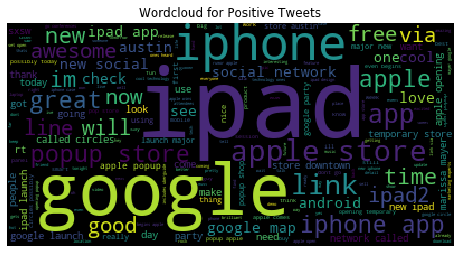

In [12]:
#Get the wordcloud for the positive tweets
make_wordcloud(pos_tweets, "Positive Tweets")

It makes sense that words like great and awesome are prominent enough to read in the positive tweets. The product names are also very prominent which makes sense. 

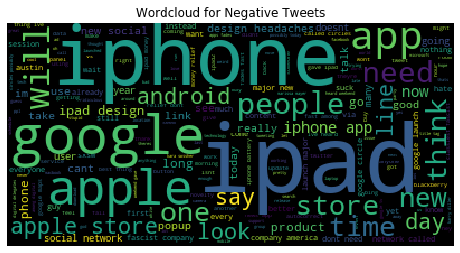

In [13]:
#Get the wordcloud for the negative tweets
make_wordcloud(neg_tweets, "Negative Tweets")

Some of the product and brand names seem larger in the negative wordcloud, particularly the Apple ones. We can further explore this by looking at the most common words for each emotion. 

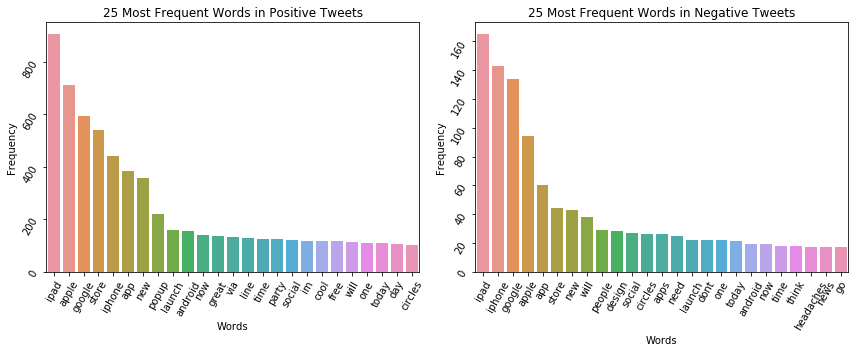

In [14]:
#Get the most frequent words for each emotion
pos_most_freq = get_most_frequent_words(pos_tweets)
neg_most_freq = get_most_frequent_words(neg_tweets)

#Seperate the words and their counts
pos_words = []
neg_words = []
pos_counts = []
neg_counts = []
for i in range(len(pos_most_freq)):
    pos_words.append(pos_most_freq[i][0])
    pos_counts.append(pos_most_freq[i][1])
    neg_words.append(neg_most_freq[i][0])
    neg_counts.append(neg_most_freq[i][1])
    
#Graph the words and their frequencies
fig, axes = plt.subplots(ncols=2, figsize=(12, 5));
sns.barplot(x=pos_words, y=pos_counts, ax=axes[0])
axes[0].set(title="25 Most Frequent Words in Positive Tweets", ylabel="Frequency", xlabel="Words")
sns.barplot(x=neg_words, y=neg_counts, ax=axes[1]) 
axes[1].set(title="25 Most Frequent Words in Negative Tweets", ylabel="Frequency", xlabel="Words")
for ax in fig.axes:
    ax.tick_params(labelrotation=60)
plt.tight_layout()

- The ipad is the most discussed product both positively and negatively.
- Contrary to the appearance in the wordcloud, Apple is mentioned more in positive tweets while Google is more mentioned in the negative tweets. 
- The iphone is mentioned more in negative tweets. 
- While great is in the top 25 positive words, headaches is more prominent in the negative words. 
- Many of the positive words seems to indicate being exposed to new content (i.e. 'popup'). While some of those words appear in the negative tweets, they appear less frequently. 
- Interestingly, need only appears as a top word for negative tweets.
- Overall the words are fairly similar.

## Embedding

Next we begin building our own embedding layer. While not shown, initially the GloVe vector pre-trained on twitter data was used, but it was missing certain important product words that are relevant to this problem. Therefore we create the vector ourselves.  

In [15]:
#We get the lowercase of each word, remove punctuation, etc. and seperate each word
tweets = data_cleaned["tweet_text"].map(lambda x: simple_preprocess(x,True))

tweets[:5]

0    [have, iphone, after, hrs, tweeting, at, it, w...
1    [know, about, awesome, ipad, iphone, app, that...
2    [can, not, wait, for, also, they, should, sale...
3    [hope, this, year, festival, isn, as, crashy, ...
4    [great, stuff, on, fri, marissa, mayer, google...
Name: tweet_text, dtype: object

In [16]:
#Create and train the model
model = Word2Vec(tweets)

model.train(tweets, total_examples=model.corpus_count,epochs=10)

(310872, 524540)

In order to check how our model learned, we view the most similar words to iphone. For the most part, the similar words make quite a bit of sense. The model has correctly realized iphone and android are similar products. It also contains words people use when talking about their phones (i.e. 'check') and things related to smartphones (i.e. 'app'). Not every word makes sense, which is why we will compare this to an embedding layer made from our tokenizer. 

In [17]:
wv = model.wv

#save the number of words in the vocabularly that the model has learned
vocab_size = len(wv.vocab)

wv.most_similar("iphone")

[('android', 0.9652711153030396),
 ('got', 0.9411822557449341),
 ('thanks', 0.9261304140090942),
 ('download', 0.9164112210273743),
 ('your', 0.9116525053977966),
 ('awards', 0.9054665565490723),
 ('my', 0.8959997892379761),
 ('our', 0.8850494623184204),
 ('or', 0.8845553994178772),
 ('blackberry', 0.8719239830970764)]

In [18]:
#We must save the model so tthat later we can load in the model and use it to make an embedding layer 
filename = "word2vec_tweets.txt"
wv.save_word2vec_format(filename)

In [19]:
#Preview our fully cleaned data
data_cleaned.head()

,tweet_text,emotion
0,". I have a G iPhone. After hrs tweeting at , i...",0
1,Know about ? Awesome iPad/iPhone app that you'...,1
2,Can not wait for also. They should sale them d...,1
3,I hope this year's festival isn't as crashy as...,0
4,"great stuff on Fri : Marissa Mayer (Google), T...",1


## Splitting the Data

In [20]:
#Set our X and y variables and split them into training, validation, and testing sets
X = data_cleaned["tweet_text"].copy()
y = data_cleaned["emotion"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=.1)

- As discussed previously, the tweets in this dataset are mostly positive. This can create problems when modeling, where the most frequent class is predicted. 
- To address this, we will undersample the positive tweets in the training set.

In [21]:
#create a new dataframe for the training data
training_data = pd.concat([X_train, y_train], axis=1)

#Get the counts of each variable
pos_count, neg_count = training_data["emotion"].value_counts()

#Check that the training data looks as it should
training_data

,tweet_text,emotion
9017,Stopped by Tron Legacy Lounge at . Audio sync ...,1
7000,These iPhone apps will keep you grooving at | ...,1
4095,"""Apple likes it if you pay them. That's what A...",0
3521,How was Fri dinner and are you enjoying ? Twit...,1
1415,Nice Move: Apple set to open popup shop in cor...,1
...,...,...
731,Its bigger than an iphone and smaller than a P...,1
5963,Having a hard time tweeting and using iPhone h...,1
1038,Google is reproducing digitally the way you or...,1
8172,"ha, wow RT Apple Opening Temporary iPad Store ...",1


In [22]:
#Sepearte the positive and negative tweets
pos_data = training_data[training_data["emotion"] == 1]
neg_data = training_data[training_data["emotion"] == 0]

#take a sample of positive tweets equal to the size of the negative tweets
pos_undersample = pos_data.sample(neg_count)
balanced_training = pd.concat([pos_undersample, neg_data], axis=0)

In [23]:
#check that there are the same number of tweets of each type and seperate the X and y data
print(balanced_training["emotion"].value_counts())
X_train = balanced_training["tweet_text"].copy()
y_train = balanced_training["emotion"].copy()

1    404
0    404
Name: emotion, dtype: int64


# Finishing Data Preparation

## Tokenizing

In order for the neural network to understand the text data we must tokenize it. 

In [24]:
tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(X_train)

#We want to preserve the order of the words so we keep them as sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val= tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

#All of the sequences must be the same length so we add extra padding to all shorter than maximum sequences
X_train_padded = pad_sequences(X_train, maxlen=32)
X_test_padded = pad_sequences(X_test, maxlen=32)
X_val_padded = pad_sequences(X_val, maxlen=32)

#Save the word indices
word_index = tokenizer.word_index

Now we can load our word2vec model back in turn it into an embedding layer.

In [25]:
#from https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
import os
embeddings_index = {}
f = open(os.path.join("", "word2vec_tweets.txt"), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_layer = Embedding(num_words, 100, input_length=len(X_train_padded[0]),
                           embeddings_initializer=Constant(embedding_matrix),
                           trainable=False)

# Modeling

We do not want our network to keep going once there is no improvement so we set up a way to stop the model from learning after a certain time period of no improvement. In our case the network will stop learning if the loss of the validation set does not decrease by .01 for 5 epochs. This gives the network some time to learn at the beginning but still be prevented from going too far. In addition we will keep the best weights so that our model is performing optimally. 

In [26]:
earlystop = EarlyStopping(monitor="val_loss", min_delta = .01, patience=5, restore_best_weights=True)

In [27]:
def visualize_training_results(results):
    """Plot the loss and accuracy of both the training and validation sets."""
    
    history = results.history
    plt.figure()
    plt.plot(history["val_loss"])
    plt.plot(history["loss"])
    plt.legend(["Validation Loss", "Training Loss"])
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    plt.figure()
    plt.plot(history["val_acc"])
    plt.plot(history["acc"])
    plt.legend(["Validation Accuracy", "Training Accuracy"])
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
def evaluate_model(model, X_test, y_test):
    """Create a classification report and confusion matrix for the model."""
    
    y_hat_test = model.predict(X_test).flatten().round()
    print(metrics.classification_report(y_test, y_hat_test, target_names=["Negative", "Positive"]))
    ax = sns.heatmap(metrics.confusion_matrix(y_test, y_hat_test, normalize="true"), cmap="YlGnBu", 
                annot=True, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    ax.set(xlabel="True Label", ylabel="Predicted Label", title="Confusion Matrix")

While recommendations vary, a good amount of sources indicate that starting with relu as the activation function and adam as the optimizer is a good starting point.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 808 samples, validate on 284 samples
Epoch 1/20
808/808 [==============================] - 2s 3ms/sample - loss: 0.6847 - acc: 0.5322 - val_loss: 0.6026 - val_acc: 0.6796
Epoch 2/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.6709 - acc: 0.5990 - val_loss: 0.6431 - val_acc: 0.5775
Epoch 3/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.6504 - acc: 0.6126 - val_loss: 0.7466 - val_acc: 0.4437
Epoch 4/20
808/808 [==============================] - 2s 2ms/sample - loss: 0.6695 - acc: 0.6300 - val_loss: 0.6776 - val_acc: 0.5669
Epoch 5/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.6454 - acc: 0.6349 - val_loss: 0.5344 - val_acc: 0.7183
Epoch 6/20
808/808 [==============================] - 1s 2ms/sample - lo

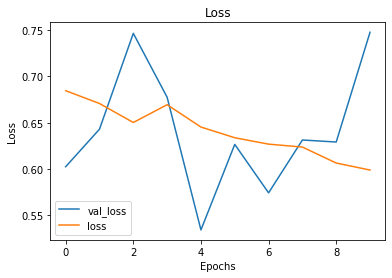

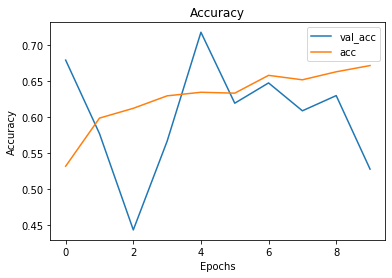

              precision    recall  f1-score   support

    Negative       0.30      0.43      0.35       115
    Positive       0.88      0.80      0.84       595

    accuracy                           0.74       710
   macro avg       0.59      0.62      0.60       710
weighted avg       0.79      0.74      0.76       710



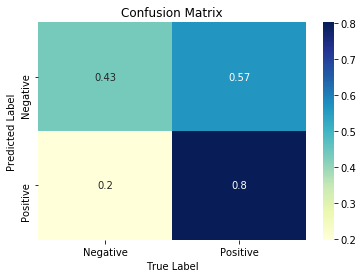

In [27]:
model1 = Sequential()
model1.add(embedding_layer)
model1.add(LSTM(units=100, activation="relu"))
model1.add(Dense(1, activation="sigmoid"))
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results1 = model1.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=20)
visualize_training_results(results1)
evaluate_model(model1, X_test_padded, y_test)

For comparison, we will see how the model does with the embedding layer created by the tokenizer. 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 808 samples, validate on 284 samples
Epoch 1/30
808/808 [==============================] - 2s 3ms/sample - loss: 0.6911 - acc: 0.5050 - val_loss: 0.6741 - val_acc: 0.7923
Epoch 2/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6462 - acc: 0.7153 - val_loss: 0.8013 - val_acc: 0.2817
Epoch 3/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.4972 - acc: 0.8007 - val_loss: 0.4394 - val_acc: 0.8099
Epoch 4/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.3086 - acc: 0.9146 - val_loss: 2.4495 - val_acc: 0.6373
Epoch 5/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.2464 - acc: 0.9542 - val_loss: 9.8434 - val_acc: 0.6796
Epoch 6/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.2139 - acc: 0.9282 - val_loss: 0.3750 - val_acc: 0.8345
Epoch 7/30
808/808 [============

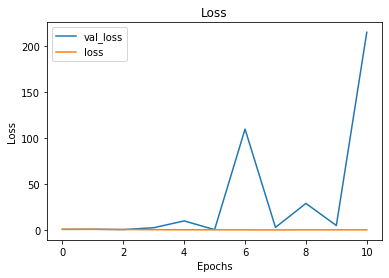

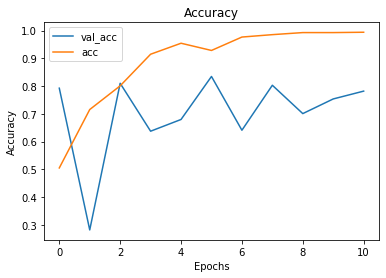

              precision    recall  f1-score   support

    Negative       0.43      0.60      0.50       115
    Positive       0.92      0.84      0.88       595

    accuracy                           0.80       710
   macro avg       0.67      0.72      0.69       710
weighted avg       0.84      0.80      0.82       710



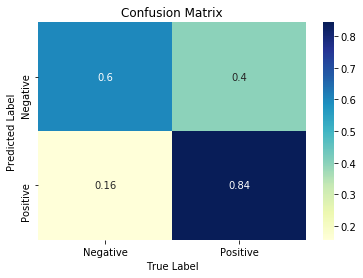

In [28]:
model2 = Sequential()
model2.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model2.add(LSTM(units=100, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results2 = model2.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results2)
evaluate_model(model2, X_test_padded, y_test)

- Based on information from multiple runnings of these models, the tokenizer-created embedding layer produces better results. Therefore we will use it going forward.  
- This model had an increase in validation loss over time so we can try different optimizers.

Train on 808 samples, validate on 284 samples
Epoch 1/30
808/808 [==============================] - 3s 3ms/sample - loss: 0.6931 - acc: 0.5050 - val_loss: 0.6958 - val_acc: 0.2042
Epoch 2/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6930 - acc: 0.5012 - val_loss: 0.6960 - val_acc: 0.2007
Epoch 3/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6929 - acc: 0.5260 - val_loss: 0.6954 - val_acc: 0.2254
Epoch 4/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6928 - acc: 0.5235 - val_loss: 0.6947 - val_acc: 0.2676
Epoch 5/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6928 - acc: 0.5285 - val_loss: 0.6946 - val_acc: 0.2711
Epoch 6/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6928 - acc: 0.5396 - val_loss: 0.6944 - val_acc: 0.3028


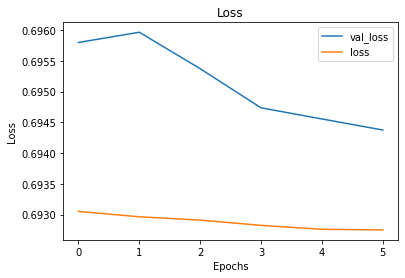

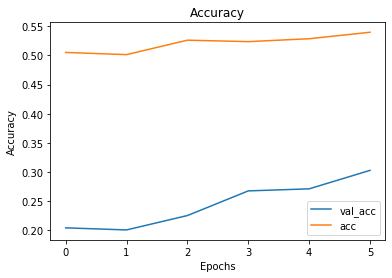

              precision    recall  f1-score   support

    Negative       0.16      0.98      0.28       115
    Positive       0.86      0.02      0.04       595

    accuracy                           0.18       710
   macro avg       0.51      0.50      0.16       710
weighted avg       0.74      0.18      0.08       710



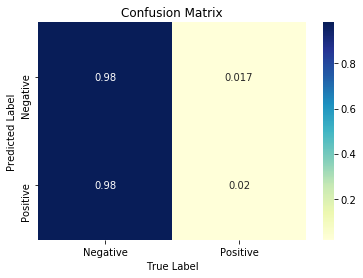

In [29]:
model3 = Sequential()
model3.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model3.add(LSTM(units=100, activation="relu"))
model3.add(Dense(1, activation="sigmoid"))
model3.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
results3 = model3.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results3)
evaluate_model(model3, X_test_padded, y_test)

The sgd optimizer did not make improvements, so we can move on.

Train on 808 samples, validate on 284 samples
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/30
808/808 [==============================] - 3s 3ms/sample - loss: 0.6920 - acc: 0.5767 - val_loss: 0.6894 - val_acc: 0.6338
Epoch 2/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6890 - acc: 0.6658 - val_loss: 0.6867 - val_acc: 0.6655
Epoch 3/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6863 - acc: 0.6980 - val_loss: 0.6838 - val_acc: 0.6761
Epoch 4/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6825 - acc: 0.7265 - val_loss: 0.6807 - val_acc: 0.6796
Epoch 5/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6756 - acc: 0.7624 - val_loss: 0.6641 - val_acc: 0.7641
Epoch 6/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.6536 - acc: 0.7611 - val_loss: 0.6016 - val_acc: 0.8099
Epoch 7/30
808/808 [============

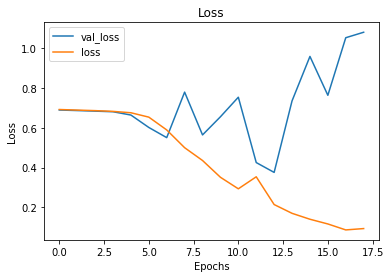

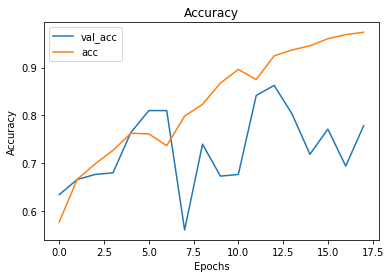

              precision    recall  f1-score   support

    Negative       0.50      0.53      0.51       115
    Positive       0.91      0.90      0.90       595

    accuracy                           0.84       710
   macro avg       0.70      0.71      0.71       710
weighted avg       0.84      0.84      0.84       710



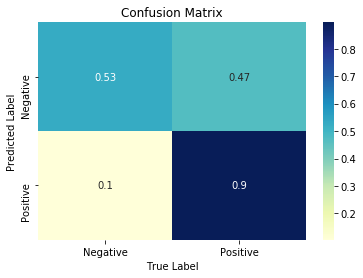

In [30]:
model4 = Sequential()
model4.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model4.add(LSTM(units=100, activation="relu"))
model4.add(Dense(1, activation="sigmoid"))
model4.compile(loss="binary_crossentropy", optimizer="Adagrad", metrics=["accuracy"])
results4 = model4.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results4)
evaluate_model(model4, X_test_padded, y_test)

This model does not do as well as the base model so we can try and control overfitting vias regularizers and dropout on the original model.

Train on 808 samples, validate on 284 samples
Epoch 1/30
808/808 [==============================] - 3s 4ms/sample - loss: 1.2723 - acc: 0.5000 - val_loss: 1.0669 - val_acc: 0.2923
Epoch 2/30
808/808 [==============================] - 1s 2ms/sample - loss: 0.9425 - acc: 0.6374 - val_loss: 0.8625 - val_acc: 0.2852
Epoch 3/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.7356 - acc: 0.6795 - val_loss: 10.6570 - val_acc: 0.6972
Epoch 4/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.4824 - acc: 0.8540 - val_loss: 1.0621 - val_acc: 0.7500
Epoch 5/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.4079 - acc: 0.9245 - val_loss: 0.4443 - val_acc: 0.8486
Epoch 6/30
808/808 [==============================] - 2s 3ms/sample - loss: 0.3215 - acc: 0.9196 - val_loss: 45.5060 - val_acc: 0.7289
Epoch 7/30
808/808 [==============================] - 2s 2ms/sample - loss: 2.9026 - acc: 0.9344 - val_loss: 0.5694 - val_acc: 0.8028
Epoch 8/30
808

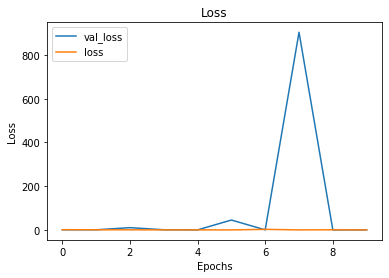

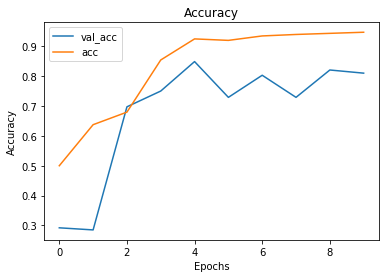

              precision    recall  f1-score   support

    Negative       0.55      0.40      0.46       115
    Positive       0.89      0.94      0.91       595

    accuracy                           0.85       710
   macro avg       0.72      0.67      0.69       710
weighted avg       0.83      0.85      0.84       710



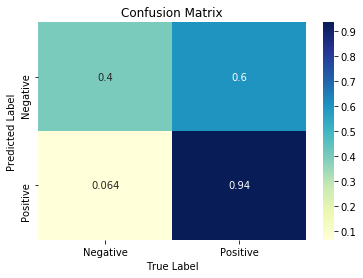

In [31]:
model5 = Sequential()
model5.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model5.add(LSTM(units=100, activation="relu", kernel_regularizer=regularizers.l2(0.005),
              recurrent_dropout=.15, dropout=.4))
model5.add(Dense(1, activation="sigmoid"))
model5.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results5 = model5.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results5)
evaluate_model(model5, X_test_padded, y_test)

Using l2 regularization did not help so we can try l1 regularization.

Train on 808 samples, validate on 284 samples
Epoch 1/30
808/808 [==============================] - 3s 4ms/sample - loss: 9.3963 - acc: 0.5012 - val_loss: 7.0948 - val_acc: 0.2359
Epoch 2/30
808/808 [==============================] - 2s 2ms/sample - loss: 5.4410 - acc: 0.6757 - val_loss: 3.7803 - val_acc: 0.4754
Epoch 3/30
808/808 [==============================] - 2s 2ms/sample - loss: 2.6914 - acc: 0.5804 - val_loss: 1.6769 - val_acc: 0.8310
Epoch 4/30
808/808 [==============================] - 2s 2ms/sample - loss: 1.1786 - acc: 0.5371 - val_loss: 0.8392 - val_acc: 0.1796
Epoch 5/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.7710 - acc: 0.5000 - val_loss: 0.7331 - val_acc: 0.8345
Epoch 6/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.7251 - acc: 0.5087 - val_loss: 0.7143 - val_acc: 0.8204
Epoch 7/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.7188 - acc: 0.5136 - val_loss: 0.7298 - val_acc: 0.1796
Epoch 8/30
808/8

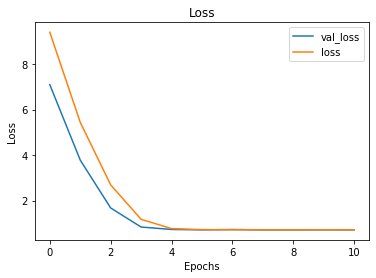

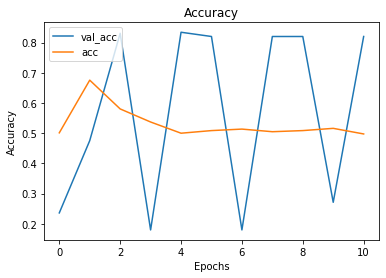

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       115
    Positive       0.84      1.00      0.91       595

    accuracy                           0.84       710
   macro avg       0.42      0.50      0.46       710
weighted avg       0.70      0.84      0.76       710



C:\Users\charlotte\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


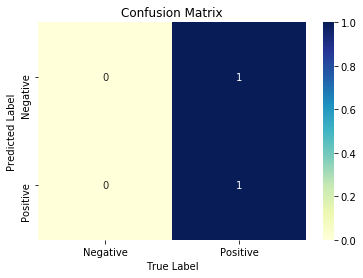

In [32]:
model6 = Sequential()
model6.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model6.add(LSTM(units=100, activation="relu", kernel_regularizer=regularizers.l1(0.005),
              recurrent_dropout=.15, dropout=.3))
model6.add(Dense(1, activation="sigmoid"))
model6.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results6 = model6.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results6)
evaluate_model(model6, X_test_padded, y_test)

- This model has very high loss (only exacerbated by further layers, as attempted but not shown) so we can move onto another approach. 
- Since we have tried different optimizers, we can also try different activation functions. 

Train on 808 samples, validate on 284 samples
Epoch 1/20
808/808 [==============================] - 2s 3ms/sample - loss: 0.6937 - acc: 0.5062 - val_loss: 0.6890 - val_acc: 0.7500
Epoch 2/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.6816 - acc: 0.6856 - val_loss: 0.7441 - val_acc: 0.3134
Epoch 3/20
808/808 [==============================] - 1s 1ms/sample - loss: 0.5532 - acc: 0.7314 - val_loss: 0.5934 - val_acc: 0.6444
Epoch 4/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.4344 - acc: 0.7970 - val_loss: 0.5836 - val_acc: 0.6937
Epoch 5/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.3057 - acc: 0.9072 - val_loss: 0.5330 - val_acc: 0.6972
Epoch 6/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.1661 - acc: 0.9443 - val_loss: 0.4763 - val_acc: 0.8134
Epoch 7/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.0903 - acc: 0.9752 - val_loss: 0.7176 - val_acc: 0.6831
Epoch 8/20
808/8

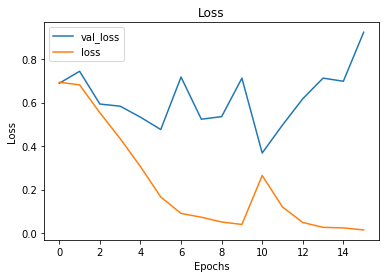

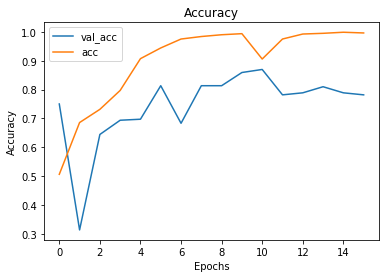

              precision    recall  f1-score   support

    Negative       0.46      0.53      0.49       115
    Positive       0.91      0.88      0.89       595

    accuracy                           0.82       710
   macro avg       0.68      0.71      0.69       710
weighted avg       0.83      0.82      0.83       710



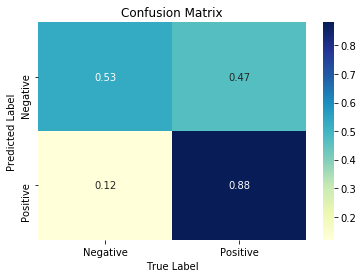

In [33]:
model7 = Sequential()
model7.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=10))
model7.add(LSTM(units=100, activation="tanh"))
model7.add(Dense(1, activation="sigmoid"))
model7.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results7 = model7.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=20)
visualize_training_results(results7)
evaluate_model(model7, X_test_padded, y_test)

Train on 808 samples, validate on 284 samples
Epoch 1/20
808/808 [==============================] - 3s 4ms/sample - loss: 0.6927 - acc: 0.5186 - val_loss: 0.6881 - val_acc: 0.7148
Epoch 2/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.6708 - acc: 0.6869 - val_loss: 0.6991 - val_acc: 0.5845
Epoch 3/20
808/808 [==============================] - 2s 2ms/sample - loss: 0.5692 - acc: 0.7550 - val_loss: 0.6216 - val_acc: 0.6620
Epoch 4/20
808/808 [==============================] - 2s 2ms/sample - loss: 0.3658 - acc: 0.8502 - val_loss: 0.4697 - val_acc: 0.7887
Epoch 5/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.2449 - acc: 0.9134 - val_loss: 0.6586 - val_acc: 0.6761
Epoch 6/20
808/808 [==============================] - 1s 2ms/sample - loss: 0.1505 - acc: 0.9493 - val_loss: 0.6212 - val_acc: 0.7606
Epoch 7/20
808/808 [==============================] - 2s 2ms/sample - loss: 0.0787 - acc: 0.9740 - val_loss: 0.6605 - val_acc: 0.7570
Epoch 8/20
808/8

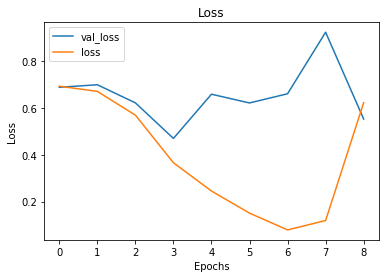

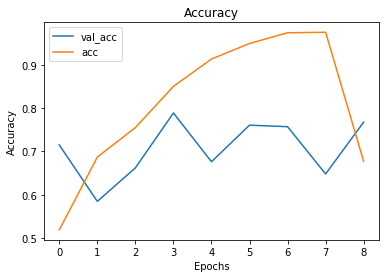

              precision    recall  f1-score   support

    Negative       0.39      0.67      0.49       115
    Positive       0.93      0.80      0.86       595

    accuracy                           0.78       710
   macro avg       0.66      0.73      0.68       710
weighted avg       0.84      0.78      0.80       710



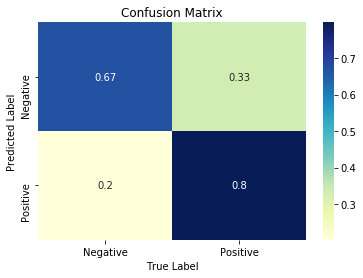

In [39]:
model8 = Sequential()
model8.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=10))
model8.add(LSTM(units=100, activation="tanh"))
model8.add(Dense(1, activation="sigmoid"))
model8.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results8 = model8.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=20)
visualize_training_results(results8)
evaluate_model(model8, X_test_padded, y_test)

This model seems worthy of further exploration to address overfitting. We can start with l2 regularization.

Train on 808 samples, validate on 284 samples
Epoch 1/30
808/808 [==============================] - 5s 6ms/sample - loss: 1.2657 - acc: 0.5359 - val_loss: 1.0644 - val_acc: 0.4120
Epoch 2/30
808/808 [==============================] - 2s 3ms/sample - loss: 0.9191 - acc: 0.6757 - val_loss: 0.8512 - val_acc: 0.5458
Epoch 3/30
808/808 [==============================] - 2s 3ms/sample - loss: 0.6088 - acc: 0.8354 - val_loss: 0.5598 - val_acc: 0.7676
Epoch 4/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.3553 - acc: 0.8973 - val_loss: 0.6078 - val_acc: 0.7359
Epoch 5/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.2717 - acc: 0.9295 - val_loss: 0.5664 - val_acc: 0.7641
Epoch 6/30
808/808 [==============================] - 2s 3ms/sample - loss: 0.1616 - acc: 0.9666 - val_loss: 0.7023 - val_acc: 0.7535
Epoch 7/30
808/808 [==============================] - 2s 3ms/sample - loss: 0.1106 - acc: 0.9851 - val_loss: 0.7174 - val_acc: 0.7289
Epoch 8/30
808/8

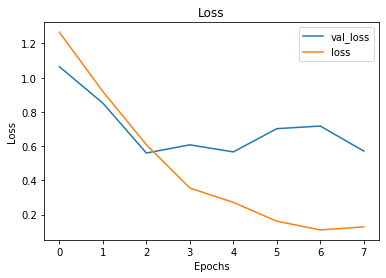

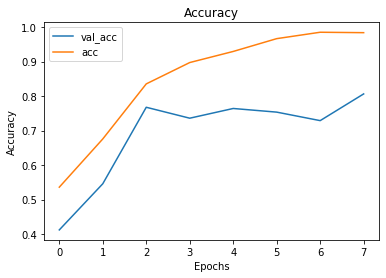

              precision    recall  f1-score   support

    Negative       0.36      0.64      0.46       115
    Positive       0.92      0.78      0.84       595

    accuracy                           0.76       710
   macro avg       0.64      0.71      0.65       710
weighted avg       0.83      0.76      0.78       710



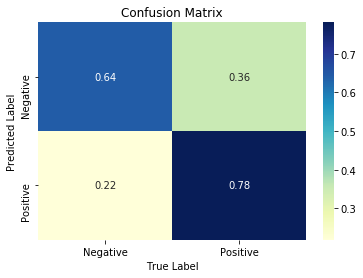

In [40]:
model9 = Sequential()
model9.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model9.add(LSTM(units=100, activation="tanh", kernel_regularizer=regularizers.l2(0.005),
              recurrent_dropout=.15, dropout=.4))
model9.add(Dense(1, activation="sigmoid"))
model9.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results9 = model9.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results9)
evaluate_model(model9, X_test_padded, y_test)

This model is an improvement but we can also try l1 regularization. 

Train on 808 samples, validate on 284 samples
Epoch 1/30
808/808 [==============================] - 5s 6ms/sample - loss: 9.4713 - acc: 0.4963 - val_loss: 7.1446 - val_acc: 0.8380
Epoch 2/30
808/808 [==============================] - 2s 3ms/sample - loss: 5.4921 - acc: 0.6498 - val_loss: 3.7793 - val_acc: 0.8310
Epoch 3/30
808/808 [==============================] - 2s 3ms/sample - loss: 2.6975 - acc: 0.6931 - val_loss: 1.7055 - val_acc: 0.6479
Epoch 4/30
808/808 [==============================] - 2s 3ms/sample - loss: 1.1284 - acc: 0.8094 - val_loss: 0.7772 - val_acc: 0.7817
Epoch 5/30
808/808 [==============================] - ETA: 0s - loss: 0.5995 - acc: 0.858 - 2s 3ms/sample - loss: 0.5983 - acc: 0.8601 - val_loss: 0.6559 - val_acc: 0.7500
Epoch 6/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.4406 - acc: 0.9059 - val_loss: 0.6226 - val_acc: 0.7676
Epoch 7/30
808/808 [==============================] - 2s 3ms/sample - loss: 0.3309 - acc: 0.9344 - val_loss: 0.6

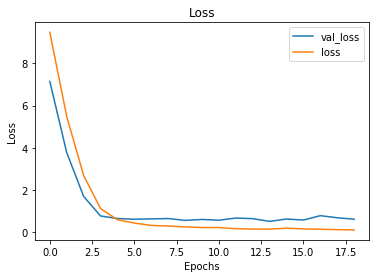

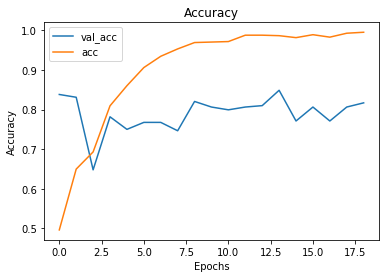

              precision    recall  f1-score   support

    Negative       0.44      0.63      0.52       115
    Positive       0.92      0.85      0.88       595

    accuracy                           0.81       710
   macro avg       0.68      0.74      0.70       710
weighted avg       0.84      0.81      0.82       710



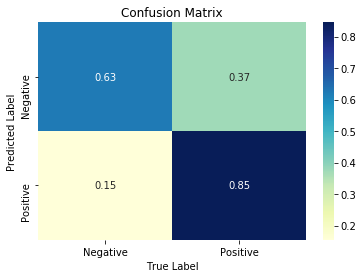

In [41]:
model10 = Sequential()
model10.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model10.add(LSTM(units=100, activation="tanh", kernel_regularizer=regularizers.l1(0.005),
              recurrent_dropout=.15, dropout=.4))
model10.add(Dense(1, activation="sigmoid"))
model10.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results10 = model10.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results10)
evaluate_model(model10, X_test_padded, y_test)

The tanh activation function does seem to result in an improved model. 

# Best Model

Although none of the models are performing as well as we might hope, the last model is our most promising so we can save it for future use. 

In [43]:
#from https://machinelearningmastery.com/save-load-keras-deep-learning-models/, save the model and weights
# model_json = model10.to_json()
# with open("best_model.json", "w") as json_file:
#     json_file.write(model_json)
# model2.save_weights("best_model.h5")

Train on 808 samples, validate on 284 samples
Epoch 1/30
808/808 [==============================] - 4s 5ms/sample - loss: 11.4738 - acc: 0.6262 - val_loss: 9.1793 - val_acc: 0.5317
Epoch 2/30
808/808 [==============================] - 2s 2ms/sample - loss: 7.3809 - acc: 0.7228 - val_loss: 5.7598 - val_acc: 0.5845
Epoch 3/30
808/808 [==============================] - 2s 2ms/sample - loss: 4.4240 - acc: 0.7785 - val_loss: 3.3871 - val_acc: 0.6514
Epoch 4/30
808/808 [==============================] - 2s 2ms/sample - loss: 2.4662 - acc: 0.8205 - val_loss: 2.0215 - val_acc: 0.6021
Epoch 5/30
808/808 [==============================] - 2s 2ms/sample - loss: 1.3820 - acc: 0.8255 - val_loss: 1.2019 - val_acc: 0.7394
Epoch 6/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.8408 - acc: 0.8502 - val_loss: 1.0279 - val_acc: 0.5951
Epoch 7/30
808/808 [==============================] - 2s 2ms/sample - loss: 0.5381 - acc: 0.8960 - val_loss: 0.9672 - val_acc: 0.6268
Epoch 8/30
808/

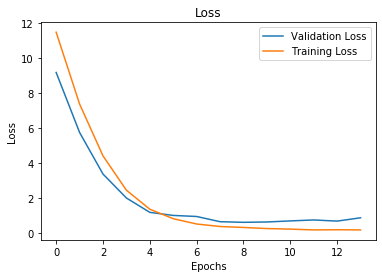

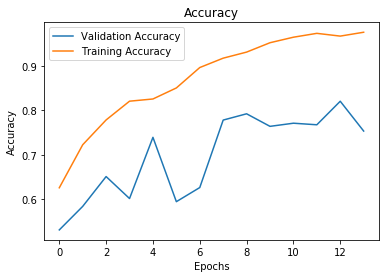

              precision    recall  f1-score   support

    Negative       0.36      0.67      0.47       115
    Positive       0.92      0.77      0.84       595

    accuracy                           0.75       710
   macro avg       0.64      0.72      0.66       710
weighted avg       0.83      0.75      0.78       710



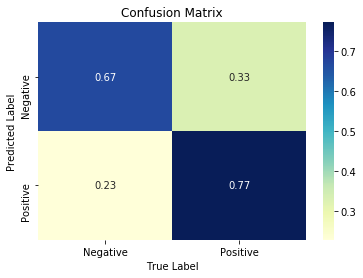

In [32]:
#from https://machinelearningmastery.com/save-load-keras-deep-learning-models/, load the model and weights
json_file = open("best_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("best_model.h5")
loaded_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
results = loaded_model.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results)
evaluate_model(loaded_model, X_test_padded, y_test)

Overall the model performs its classification task fairly well. While the validation accuracy is very unstable and the model is overfit, it is more accurate than random chance.  

In [30]:
loaded_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 32, 100)           275800    
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 356,301
Trainable params: 356,301
Non-trainable params: 0
_________________________________________________________________


# Conclusion

&nbsp; &nbsp; &nbsp; Our model performs better than chance at identifying whether a tweet was positive or negative. As one would expect, more positive words are a good indication that a tweet is speaking positively about the product and vice versa. Action words, i.e. will, are more common in negative tweets, perhaps indicating that people are tweeting about their intention to stop using a product. From our examination of the top 25 words for each emotion, it appears that people tended to tweet more positively about the excitement of new products. A good portion of this data came from tweets relating to SXSW, a singular event that may not paint a full picture of positive and negative tweets. In addition, because of the class imbalance, these models were trained on fairly small datasets so more data would be useful. Lastly, in this case we did not use the neutral tweet data and it should be examined in the future. 